<a href="https://colab.research.google.com/github/kdj0712/study_AIs/blob/main/docs/quests/NLPs/classification_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사전작업

In [ ]:
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [65]:
!pip install WordCloud

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install python-mecab-ko

In [2]:
!pip install konlpy

## 모델 대상화 데이터 준비
- DDA,EDA 확인

In [3]:
import pandas as pd

In [4]:
df_train =  pd.read_csv('/content/drive/MyDrive/data_analytics/NLP(Natural Language Processing)/Quest/train_data.csv')
df_topic = pd.read_csv('/content/drive/MyDrive/data_analytics/NLP(Natural Language Processing)/Quest/topic_dict.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data_analytics/NLP(Natural Language Processing)/Quest/test_data.csv')

In [5]:
df_topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [6]:
df_train[:2]

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4


In [7]:
df_test[:2]

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [9]:
df_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   topic      7 non-null      object
 1   topic_idx  7 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


In [10]:
df_topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   9131 non-null   int64 
 1   title   9131 non-null   object
dtypes: int64(1), object(1)
memory usage: 142.8+ KB


### 데이터 전처리
- trainset, testset 병합
- tokenizing : 머신에게 맞게 Vector

In [12]:
raw_concat = pd.concat([df_train,df_test])
raw_concat.shape, df_train.shape, df_test.shape

((54785, 3), (45654, 3), (9131, 2))

In [13]:
# 숫자 삭제
raw_concat['title_preprocess'] = raw_concat['title'].str.replace('[0-9]','',regex=True)

In [14]:
# 영어 대문자 -> 소문자로 변환
raw_concat['title_preprocess'] = raw_concat['title_preprocess'].str.lower()

In [15]:
raw_concat['title_preprocess'].str.findall('[A-Z]').value_counts()

[]    54785
Name: title_preprocess, dtype: int64

In [16]:
from konlpy.tag import Okt
okt = Okt()

In [17]:
# 조사, 어미, 구두점 등 제거
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean_text.append(word[0])

    return " ".join(clean_text)

In [18]:
raw_concat['title_okt_clean'] = raw_concat['title_preprocess'].apply(okt_clean)

In [19]:
raw_concat[:5]

,index,title,topic_idx,title_preprocess,title_okt_clean
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,인천→핀란드 항공기 결항…휴가철 여행객 분통,인천 → 핀란드 항공기 결항 휴가 철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,실리콘밸리 넘어서겠다…구글 조원 들여 美전역 거점화,실리콘밸리 넘어서다 구글 조원 들이다 美 전역 거점 화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,이란 외무 긴장 완화 해결 책 미국 경제 전쟁 멈추다 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,nyt 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,nyt 클린턴 측근 韓 기업 특수 관계 조명 공과 사 맞다 물리다 종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,시진핑 트럼프에 중미 무역협상 조속 타결 희망,시진핑 트럼프 중미 무역 협상 조속 타결 희망


In [20]:
# tokeninzing
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(tokenizer=None, ngram_range=(1,2))

In [21]:
tfidfVectorizer.fit(raw_concat['title_okt_clean'])

TfidfVectorizer(ngram_range=(1, 2))

In [22]:
# trainset, testset 분리
trainset = raw_concat[raw_concat['topic_idx'].notnull()] # train
testset = raw_concat[raw_concat['topic_idx'].isnull()] # test
trainset.shape, testset.shape

((45654, 5), (9131, 5))

In [23]:
from mecab import MeCab
mecab = MeCab()

### 모델

In [24]:
train_target = trainset['topic_idx']
train_feature = tfidfVectorizer.transform(trainset['title_okt_clean']) # 머신 학습 위한 선작업

In [25]:
from sklearn.ensemble import RandomForestClassifier
randomForestClassifier = RandomForestClassifier(n_jobs=-1)

In [26]:
# model = randomForestClassifier.fit(X=train_feature, y=train_target)

In [27]:
import pickle
# with open('ITnews.pkl','wb') as pickle_file :
#   pickle.dump(obj=randomForestClassifier.fit(X=train_feature, y=train_target), file=pickle_file)

## 모델 적용 데이터

### read excel ifle with sheets

In [28]:
df_ITNews = pd.read_excel('/content/drive/MyDrive/data_analytics/CSV파일/IT News.xlsx',sheet_name=None)

In [29]:
df_sheets = []
for sheet_name,df in df_ITNews.items():
  df_sheets.append(df)
  print(f'{sheet_name},{type(df)}')
  pass
len(df_sheets)

2024-01-31,<class 'pandas.core.frame.DataFrame'>
2024-01-30,<class 'pandas.core.frame.DataFrame'>
2024-01-29,<class 'pandas.core.frame.DataFrame'>
2024-01-26,<class 'pandas.core.frame.DataFrame'>
2024-01-25,<class 'pandas.core.frame.DataFrame'>
2024-01-24,<class 'pandas.core.frame.DataFrame'>
2024-01-23,<class 'pandas.core.frame.DataFrame'>
2024-01-22,<class 'pandas.core.frame.DataFrame'>
2024-1-19,<class 'pandas.core.frame.DataFrame'>
2024-1-18,<class 'pandas.core.frame.DataFrame'>
2024-1-17,<class 'pandas.core.frame.DataFrame'>
2024-1-16,<class 'pandas.core.frame.DataFrame'>
2024-1-15,<class 'pandas.core.frame.DataFrame'>
2024-1-12,<class 'pandas.core.frame.DataFrame'>
2024-1-11,<class 'pandas.core.frame.DataFrame'>
2024-1-10,<class 'pandas.core.frame.DataFrame'>
2024-1-9,<class 'pandas.core.frame.DataFrame'>
2024-1-8,<class 'pandas.core.frame.DataFrame'>
2024-1-5,<class 'pandas.core.frame.DataFrame'>
2024-1-4,<class 'pandas.core.frame.DataFrame'>
2024-01-03,<class 'pandas.core.frame

45

In [30]:
df_sheets[0][10:11]

,이름,선호도 투표,뉴스명,문장 요약,한 줄평
10,김덕재,NaN,"음악가 71% ""AI로 생계 잃을 것"" 우려…작사·작곡에는 활용",프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...,AI의 발전도에 따라 산업의 방향성도 변화하고 있다


In [31]:
df_sheets_iloc = []
for x in range(len(df_sheets)):
  df_sheets_iloc.append(df_sheets[x].iloc[10][3])
  print(f'{sheet_name},{type(df)}')
  pass

df_sheets_iloc = pd.DataFrame(df_sheets_iloc, columns=['summary'])
len(df_sheets_iloc)

2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'pandas.core.frame.DataFrame'>
2023-12-13,<class 'p

45

In [32]:
df_ITNews_sheets = pd.DataFrame(df_sheets_iloc).dropna()
df_ITNews_sheets[:2]

,summary
0,프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...
1,이에 대해 오픈 AI는 NYT가 악의적인 프롬프트 조작으로 일종의 버그 현상인 ‘역...


In [33]:
morphs_nouns_test = []
morphs_nouns_list_test = []
for sentence in df_ITNews_sheets['summary']:
  morphs = mecab.nouns(sentence)
  morphs_nouns_test.append(morphs)
  morphs_nouns_list_test = morphs_nouns_list_test + morphs
  pass

In [34]:
df_ITNews_sheets.reset_index(drop=True, inplace=True)
df_ITNews_sheets

,summary
0,프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...
1,이에 대해 오픈 AI는 NYT가 악의적인 프롬프트 조작으로 일종의 버그 현상인 ‘역...
2,당연히 은행 직원일 것으로 예상했다. 하지만 전화를 걸어온 것은 사람이 아니라 인공...
3,"""FSD 베타12는 수 백만 개의 영상 클립으로 훈련된 단일 종단간 신경망으로 업..."
4,스캐터랩은 국내에서 챗GPT 열풍이 불기 전 생성형 AI 기술을 접목해 눈길을 끌었다
5,로봇이 주변 환경을 인식하고 스스로의 행동을 분석해 작업을 개선하는 대규모 인공지능...
6,"데이터 수집부터 정제, 가공, 평가까지 모든 프로세스를 제공하는 기술이다. 신제품 ..."
7,브로드컴은 새로운 제품 라인업과 구독 라이선스를 발표하면서 기존보다 기본 가격을 5...
8,"골드만삭스, 2035년까지 3억개 일자리 사라질 것\n'인력 감축' IT업계는 비핵..."
9,한동안 경쟁적으로 일어났던 기업 내 인공지능(AI) 도입이 지지부진한 상태에 머무르...


In [35]:
morphs_nouns_test,type(morphs_nouns_test),len(morphs_nouns_test)

([['프랑스',
   '독일',
   '음악가',
   '열',
   '일곱',
   '생성',
   '인공지능',
   '생계',
   '위협',
   '여론',
   '조사',
   '결과',
   '일',
   '현지',
   '시간',
   '공개'],
  ['이',
   '오픈',
   '악의',
   '프롬프트',
   '조작',
   '일종',
   '버그',
   '현상',
   '역류',
   '유발',
   '반박',
   '역류',
   '규모',
   '생성',
   '모델',
   '데이터',
   '훈련',
   '과정',
   '번',
   '입력',
   '해당',
   '데이터',
   '암기',
   '확률',
   '오류',
   '현상',
   '말',
   '본지',
   '년',
   '월',
   '일자',
   '면',
   '노혜령',
   '시리즈',
   '편',
   '참조',
   '암기',
   '증명',
   '저작',
   '위반',
   '수'],
  ['은행', '직원', '것', '예상', '전화', '것', '사람', '인공지능', '상담원'],
  ['베타',
   '백만',
   '개',
   '영상',
   '클립',
   '훈련',
   '단일',
   '종단',
   '간',
   '신경망',
   '업그레이드',
   '만',
   '줄',
   '이상',
   '명시',
   '코드',
   '대체'],
  ['터', '랩', '국내', '챗', '열풍', '전', '생성', '기술', '접목', '눈길'],
  ['로봇',
   '주변',
   '환경',
   '인식',
   '스스로',
   '행동',
   '분석',
   '작업',
   '개선',
   '규모',
   '인공지능',
   '모델',
   '기반',
   '학습',
   '도구',
   '구글',
   '공개'],
  ['데이터',
   '수집',
   '정제',
   '가공',
   '평가',
   '프로세스'

In [36]:
df_ITNews_sheets['morphs_list'] = [[] for _ in range(len(df_ITNews_sheets))]
for x in range(len(morphs_nouns_test)):
  df_ITNews_sheets.at[x,'morphs_list'] = ' '.join(map(str, morphs_nouns_test[x]))
df_ITNews_sheets

,summary,morphs_list
0,프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...,프랑스 독일 음악가 열 일곱 생성 인공지능 생계 위협 여론 조사 결과 일 현지 시간 공개
1,이에 대해 오픈 AI는 NYT가 악의적인 프롬프트 조작으로 일종의 버그 현상인 ‘역...,이 오픈 악의 프롬프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생성 모델 ...
2,당연히 은행 직원일 것으로 예상했다. 하지만 전화를 걸어온 것은 사람이 아니라 인공...,은행 직원 것 예상 전화 것 사람 인공지능 상담원
3,"""FSD 베타12는 수 백만 개의 영상 클립으로 훈련된 단일 종단간 신경망으로 업...",베타 백만 개 영상 클립 훈련 단일 종단 간 신경망 업그레이드 만 줄 이상 명시 코...
4,스캐터랩은 국내에서 챗GPT 열풍이 불기 전 생성형 AI 기술을 접목해 눈길을 끌었다,터 랩 국내 챗 열풍 전 생성 기술 접목 눈길
5,로봇이 주변 환경을 인식하고 스스로의 행동을 분석해 작업을 개선하는 대규모 인공지능...,로봇 주변 환경 인식 스스로 행동 분석 작업 개선 규모 인공지능 모델 기반 학습 도...
6,"데이터 수집부터 정제, 가공, 평가까지 모든 프로세스를 제공하는 기술이다. 신제품 ...",데이터 수집 정제 가공 평가 프로세스 제공 기술 제품 공개 스마트 모빌리티 스마트 ...
7,브로드컴은 새로운 제품 라인업과 구독 라이선스를 발표하면서 기존보다 기본 가격을 5...,브로드컴 제품 라인업 구독 라이선스 발표 기존 기본 가격 인하 강조
8,"골드만삭스, 2035년까지 3억개 일자리 사라질 것\n'인력 감축' IT업계는 비핵...",골드만 삭스 년 억 개 일자리 것 인력 감축 업계 핵심 사업 부서 업무 대체
9,한동안 경쟁적으로 일어났던 기업 내 인공지능(AI) 도입이 지지부진한 상태에 머무르...,한동안 경쟁 기업 내 인공지능 도입 지지부진 상태 것 조사


In [37]:
df_ITNews_sheets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   summary      22 non-null     object
 1   morphs_list  22 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes


In [38]:
import re
def regex_df(df, column, patterns, repl):
  df['new'] = df[column]
  for pattern in patterns:
    df['new'] = df['new'].str.replace(pattern,repl)
  return df

patterns = '(으로 |에서의 |있다|에 |로 |은 |는 |이 |가 |과 |되고 |등 |의 |를 |을 |하며|며 |데 |\.|\,|\'|\n)'
repl = ' '
df_ITNews_sheets = regex_df(df_ITNews_sheets,'morphs_list',patterns,repl)
print(df_ITNews_sheets)

                                              summary  \
0   프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...   
1   이에 대해 오픈 AI는 NYT가 악의적인 프롬프트 조작으로 일종의 버그 현상인 ‘역...   
2   당연히 은행 직원일 것으로 예상했다. 하지만 전화를 걸어온 것은 사람이 아니라 인공...   
3    "FSD 베타12는 수 백만 개의 영상 클립으로 훈련된 단일 종단간 신경망으로 업...   
4     스캐터랩은 국내에서 챗GPT 열풍이 불기 전 생성형 AI 기술을 접목해 눈길을 끌었다   
5   로봇이 주변 환경을 인식하고 스스로의 행동을 분석해 작업을 개선하는 대규모 인공지능...   
6   데이터 수집부터 정제, 가공, 평가까지 모든 프로세스를 제공하는 기술이다. 신제품 ...   
7   브로드컴은 새로운 제품 라인업과 구독 라이선스를 발표하면서 기존보다 기본 가격을 5...   
8   골드만삭스, 2035년까지 3억개 일자리 사라질 것\n'인력 감축' IT업계는 비핵...   
9   한동안 경쟁적으로 일어났던 기업 내 인공지능(AI) 도입이 지지부진한 상태에 머무르...   
10  오픈AI는 북한의 해킹 조직 김수키가 대규모 사이버 공격에 인공지능(AI) 서비스를...   
11                       항저우방송국 실제 앵커 본딴 AI 앵커가 뉴스 진행   
12  2014년 설립된 국내 유니콘(기업가치 1조원 이상) 스타트업 '하이퍼커넥트'는 글...   
13  전 세계 주요 기업들이 생성 인공지능(AI)에 이어 휴머노이드 로봇 기술 확보에 힘...   
14  아마존이 구글의 쿠키 삭제 조치에 맞서 온라인 광고 타겟팅을 위한 고객 데이터를 확...   
15  “기업에서 인공지능(AI) 서비스를 구축하더라도 이를 받쳐줄 인프라가 없다면 충분한...   
16  중국 사지마비환자, 뇌에 칩 이식 통해 동작 실현

<ipython-input-38-46c5d603914e>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['new'] = df['new'].str.replace(pattern,repl)


In [39]:
df_ITNews_sheets['new']

0     프랑스 독일 음악  열 일곱 생성 인공지능 생계 위협 여론 조사 결  일 현지 시간 공개
1       오픈 악  프롬프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생성 모델 ...
2                            행 직원 것 예상 전화 것 사람 인공지능 상담원
3     베타 백만 개 영상 클립 훈련 단일 종단 간 신경망 업그레 드 만 줄  상 명시 코...
4                             터 랩 국내 챗 열풍 전 생성 기술 접목 눈길
5      봇 주변 환경 인식 스스  행동 분석 작업 개선 규모 인공지능 모델 기반 학습 도...
6       터 수집 정제  공 평  프 세스 제공 기술 제품 공개 스마트 모빌리티 스마트 ...
7                 브 드컴 제품 라인업 구독 라 선스 발표 기존 기본  격 인  강조
8            골드만 삭스 년 억 개 일자리 것 인력 감축 업계 핵심 사업 부  업무 대체
9                      한동안 경쟁 기업 내 인공지능 도입 지지부진 상태 것 조사
10    오픈 북한 해킹 조직 김수 키 규모 사 버 공격 인공지능  비스 사용 정황 확인   제재
11                               항저우 방송국 실제 앵커 앵커 뉴스 진행
12    년 설립 국내 유니콘 기업  치 조 원  상 스타트업   퍼 커넥트 글 벌 영상 스...
13                       세계 주요 기업 인공지능 휴머노 드  봇 기술 확보 힘
14              아마존 구글 쿠키 삭제 조치 온라인 광   객   터 확보 본격 움직임
15    기업 인공지능  비스 구축   인프라 효  기대 수 대 수 기업   독자 구축 비용...
16    중국 사지 마비 환자 뇌 칩  식 동작 실현 신경 전자 기회  식 마비 환자 진전 ...
17    거대 추진 협 회 건 문 제출 후 저작  슈 공동 대응 제안 문  칭 공표 

In [40]:
df_ITNews_sheets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   summary      22 non-null     object
 1   morphs_list  22 non-null     object
 2   new          22 non-null     object
dtypes: object(3)
memory usage: 656.0+ bytes


In [41]:
df_ITNews_sheets['okt_new'] = df_ITNews_sheets['new'].apply(okt_clean)
df_ITNews_sheets['okt_new']

0     프랑스 독일 음악 열 일곱 생 성 인공 지능 생계 위협 여론 조사 결 일 현지 시간 공개
1     오픈 악 프롬 프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생 성 모델 터...
2                          행 직원 것 예상 전화 것 사람 인공 지능 상담 원
3     베타 백만 개 영상 클립 훈련 단일 종단 간 신경망 업그레 드 만 줄 상 명시 코드 대체
4                            터 랩 국내 챗 열풍 전 생 성 기술 접목 눈길
5     봇 주변 환경 인식 스스 행동 분석 작업 개선 규모 인공 지능 모델 기반 학습 도구...
6     터 수집 정제 공 평 프 세스 제공 기술 제품 공개 스마트 모빌리티 스마트 시티 스...
7                     브 드컴 제품 라인업 구독 선스 발표 기존 기본 격 인 강조
8              골드 삭스 년 억 개 일자리 것 인력 감축 업계 핵심 사업 부 업무 대체
9                    한동안 경쟁 기업 내 인공 지능 도입 지지 부진 상태 것 조사
10      오픈 북한 해킹 조직 김수 키 규모 사 버 공격 인공 지능 비스 사용 정황 확인 제재
11                               항저우 방송국 실제 앵커 앵커 뉴스 진행
12    년 설립 국내 유니콘 기업 치 조 원 상 스타트업 퍼 커넥트 글 벌 영상 스트리밍 ...
13                      세계 주요 기업 인공 지능 휴 멀다 드 봇 기술 확보 힘
14                  아마존 구글 쿠키 삭제 조치 온라인 광 객 터 확보 본격 움직임
15    기업 인공 지능 비스 구축 인프라 효 기대 수 대다 수 기업 독자 구축 비용 역량 ...
16    중국 사지 마비 환자 뇌 칩 식 동작 실현 신경 전자 기회 식 마비 환자 진전 中 ...
17    거대 추진 협 회 건 문 제출 후 저작 슈 공동 대응 제안 문 칭 공표 저작

In [42]:
news_token = tfidfVectorizer.transform(df_ITNews_sheets['okt_new'])
news_token

<22x271262 sparse matrix of type '<class 'numpy.float64'>'
	with 306 stored elements in Compressed Sparse Row format>

In [43]:
token_array = news_token.toarray()

In [44]:
import numpy as np
np.where(news_token.toarray() > 0)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
        11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
        16, 

In [45]:
file_path = '/content/ITnews.pkl'
with open(file_path, 'rb') as pickle_file:
  loaded_model = pickle.load(pickle_file)

In [46]:
token_model_array = loaded_model.predict(news_token.toarray())
list_token = token_model_array.tolist()
list_token

[0.0,
 2.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 4.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [47]:
int_list_token = []
for x in range(len(list_token)):
  int_list_token.append(int(list_token[x]))
print(int_list_token)

[0, 2, 0, 5, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 4, 2, 0, 0, 0, 0]


In [48]:
len(list_token)

22

In [49]:
df_topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [50]:
df_ITNews_sheets.iloc[16]

summary        중국 사지마비환자, 뇌에 칩 이식 통해 동작 실현\n"'신경 전자 기회' 이식, 마...
morphs_list    중국 사지 마비 환자 뇌 칩 이식 동작 실현 신경 전자 기회 이식 마비 환자 진전 ...
new            중국 사지 마비 환자 뇌 칩  식 동작 실현 신경 전자 기회  식 마비 환자 진전 ...
okt_new        중국 사지 마비 환자 뇌 칩 식 동작 실현 신경 전자 기회 식 마비 환자 진전 中 ...
Name: 16, dtype: object

In [51]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white'
                      ,font_path="/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")

In [52]:
for x in range(len(list_token)):
  if isinstance(x,pd.DataFrame):
    df_ITNews_sheets(df_ITNews_sheets['token']) == x.values
  else:
    pass

In [53]:
token_series = pd.Series(int_list_token)
token_series

0     0
1     2
2     0
3     5
4     0
5     0
6     0
7     2
8     2
9     0
10    0
11    2
12    1
13    0
14    0
15    0
16    4
17    2
18    0
19    0
20    0
21    0
dtype: int64

In [54]:
token_series.value_counts()

0    14
2     5
5     1
1     1
4     1
dtype: int64

In [55]:
from collections import Counter
text_split_counter = Counter(token_series)
text_split_counter

Counter({0: 14, 2: 5, 5: 1, 1: 1, 4: 1})

In [56]:
token_series = token_series.rename('token_series')

In [57]:
concat_ITnews = pd.concat([df_ITNews_sheets,token_series],axis=1)
concat_ITnews[:2]

,summary,morphs_list,new,okt_new,token_series
0,프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...,프랑스 독일 음악가 열 일곱 생성 인공지능 생계 위협 여론 조사 결과 일 현지 시간 공개,프랑스 독일 음악 열 일곱 생성 인공지능 생계 위협 여론 조사 결 일 현지 시간 공개,프랑스 독일 음악 열 일곱 생 성 인공 지능 생계 위협 여론 조사 결 일 현지 시간 공개,0
1,이에 대해 오픈 AI는 NYT가 악의적인 프롬프트 조작으로 일종의 버그 현상인 ‘역...,이 오픈 악의 프롬프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생성 모델 ...,오픈 악 프롬프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생성 모델 ...,오픈 악 프롬 프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생 성 모델 터...,2


In [58]:
new_df_word = pd.merge(concat_ITnews, df_topic[['topic_idx', 'topic']], left_on='token_series', right_on='topic_idx', how='left')
new_df_word[:2]

,summary,morphs_list,new,okt_new,token_series,topic_idx,topic
0,프랑스·독일의 음악가 열에 일곱은 생성형 인공지능(AI)으로 생계에 위협을 느낀다는...,프랑스 독일 음악가 열 일곱 생성 인공지능 생계 위협 여론 조사 결과 일 현지 시간 공개,프랑스 독일 음악 열 일곱 생성 인공지능 생계 위협 여론 조사 결 일 현지 시간 공개,프랑스 독일 음악 열 일곱 생 성 인공 지능 생계 위협 여론 조사 결 일 현지 시간 공개,0,0,IT과학
1,이에 대해 오픈 AI는 NYT가 악의적인 프롬프트 조작으로 일종의 버그 현상인 ‘역...,이 오픈 악의 프롬프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생성 모델 ...,오픈 악 프롬프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생성 모델 ...,오픈 악 프롬 프트 조작 일종 버그 현상 역류 유발 반박 역류 규모 생 성 모델 터...,2,2,사회


In [59]:
values = new_df_word['topic'].value_counts()
values

IT과학    14
사회       5
스포츠      1
경제       1
세계       1
Name: topic, dtype: int64

In [60]:
topic_counter = Counter(new_df_word['topic'])
topic_counter

Counter({'IT과학': 14, '사회': 5, '스포츠': 1, '경제': 1, '세계': 1})

In [61]:
wordcloud.generate_from_frequencies(topic_counter)

In [66]:
wordcloud.words_

{'IT과학': 1.0,
 '사회': 0.35714285714285715,
 '스포츠': 0.07142857142857142,
 '경제': 0.07142857142857142,
 '세계': 0.07142857142857142}

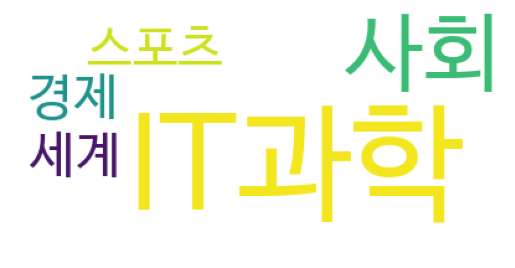

In [67]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis('off')
plt.show()